
<br>
<font style="font-family:Gabriola; font-size:400%;font-weight:bold;color:DarkOliveGreen;">Importing Modules and Libraries
  </font><br>  


In [1]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 40.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM,Dense
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')

2024-05-13 16:16:52.237173: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-13 16:16:52.237426: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-13 16:16:52.380783: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered



<br>
<font style="font-family:Gabriola; font-size:400%;font-weight:bold;color:DarkOliveGreen;">Data Loading
  </font><br>  


In [3]:
data=pd.read_csv('/kaggle/input/google/GOOG.csv')


<br>
<font style="font-family:Gabriola; font-size:400%;font-weight:bold;color:DarkOliveGreen;">Data Preparation
  </font><br>  


In [4]:
data.Date=pd.to_datetime(data.Date)
data.set_index('Date',inplace=True)

<Axes: xlabel='Date'>

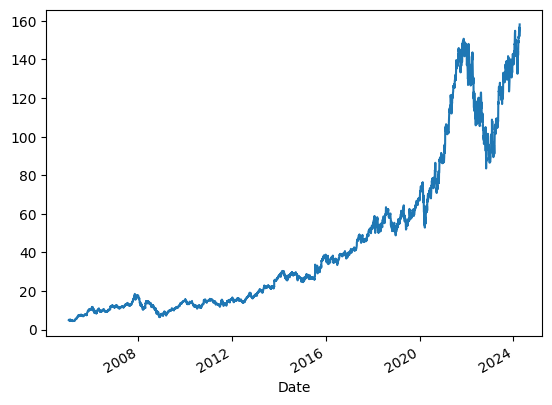

In [5]:
data.Close.plot()

In [6]:
newdf=data.Close


<br>
<font style="font-family:Gabriola; font-size:400%;font-weight:bold;color:DarkOliveGreen;">Splitting Data
  </font><br>  


In [7]:
train_size=round(newdf.shape[0]*0.80)

In [8]:
validation_size=test_size=round(newdf.shape[0]*0.10)

In [9]:
train=newdf[:train_size]

In [10]:
validation=newdf[train_size:train_size+validation_size]

In [11]:
test=newdf[train_size+validation_size:]

In [12]:
arima_train=pd.concat([train,validation])


<br>
<font style="font-family:Gabriola; font-size:400%;font-weight:bold;color:DarkOliveGreen;">ARIMA MODEL
  </font><br>  


In [13]:
model=auto_arima(arima_train)

In [14]:
result=model.fit(arima_train)

In [15]:
predict=result.predict(30)

In [16]:
arima_train=arima_train.reset_index().Close


<br>
<font style="font-family:Gabriola; font-size:400%;font-weight:bold;color:DarkOliveGreen;">Predicted Values
  </font><br>  


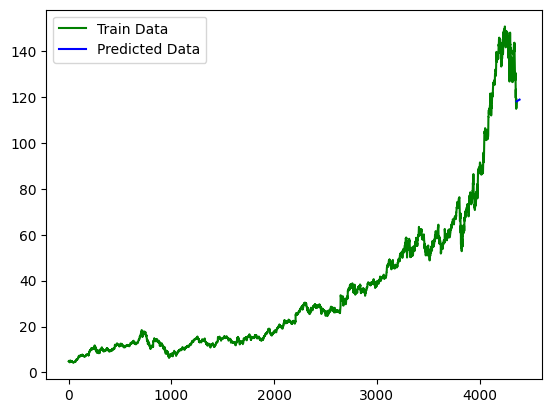

In [17]:
arima_train.plot(label="Train Data",color='g')
predict.plot(label='Predicted Data',color='blue')
plt.legend()

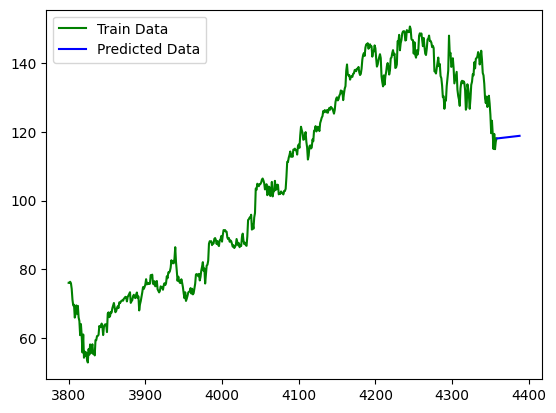

In [18]:
arima_train[3800:].plot(label="Train Data",color='g')
predict.plot(label='Predicted Data',color='blue')
plt.legend()


<br>
<font style="font-family:Gabriola; font-size:400%;font-weight:bold;color:DarkOliveGreen;">LSTM Model
  </font><br>  


In [19]:
def func(df):
  return np.array(df).reshape(-1,100)
train=train[75:]
validation=validation[84:]
test=test[85:]
train=func(train)
validation=func(validation)
test=func(test)
xtra,ytra=train[:,:-1],train[:,-1].reshape(1,-1)
xval,yval=validation[:,:-1],validation[:,-1].reshape(1,-1)
xtest,ytest=test[:,:-1],test[:,-1].reshape(1,-1)
scaler=MinMaxScaler()
scaler2=MinMaxScaler()
def func1(df):
  return scaler.fit_transform(df)
xtra,ytra=func1(xtra),scaler2.fit_transform(ytra)
xval,yval=func1(xval),scaler2.fit_transform(yval)
xtest,ytest=func1(xtest),scaler2.fit_transform(ytest)
def func3(df):
  return df.reshape(df.shape[0],df.shape[1],1)
xtra=func3(xtra)
xval=func3(xval)
xtest=func3(xtest)

In [20]:
input_shape=(99,1)
hidden_nodes=50

In [21]:
model=Sequential()
model.add(LSTM(hidden_nodes,return_sequences=True,input_shape=input_shape))
model.add(LSTM(hidden_nodes))
model.add(Dense(1))
model.compile(loss='mse',optimizer='adam')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 99, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
ytra=ytra.flatten()
ytest=ytest.flatten()
yval=yval.flatten()

In [23]:
cr=tf.keras.callbacks.EarlyStopping(patience=5,monitor='val_loss')

In [24]:
model.fit(xtra,ytra,validation_data=(xval,yval),epochs=100,verbose=1,callbacks=[cr])

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 449ms/step - loss: 7.9195e-04 - val_loss: 8.2103e-05
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 1.8134e-04 - val_loss: 0.0025
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0012 - val_loss: 9.0592e-04
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 3.1559e-04 - val_loss: 4.4565e-05
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 1.3515e-04 - val_loss: 7.1656e-04
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 5.2329e-04 - val_loss: 4.7140e-04
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 2.3793e-04 - val_loss: 1.2910e-05
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 2.7152e-05 - val_loss: 2.0898e-04
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 1.2277e-04 - val_loss: 4.1263e-04
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 2.2203e-04 - val_loss: 2.5330e-04
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 1.1882e-04 - val_loss: 2.89

In [25]:
ypred=model.predict(xtest)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


In [26]:
ytest=scaler2.inverse_transform(ytest.reshape(1,-1))

In [27]:
ypred=ypred.reshape(1,-1)

In [28]:
ypred=scaler2.inverse_transform(ypred)


<br>
<font style="font-family:Gabriola; font-size:400%;font-weight:bold;color:DarkOliveGreen;">LSTM model Evaluation
  </font><br>  


In [29]:
mean_squared_error(ytest,ypred)

3.435819575150181e-05